# Geospatial file format Performance Evaluation

This notebook contains: 
- An Overview of the GeoParquet standard
- Benchmark code for evaluating the GeoParquet file format using the following datasets:
    - The [Google-Microsoft combined Open Buildings](https://beta.source.coop/vida/google-microsoft-open-buildings/) for 2D building footprint data
    - The [Overture buildings dataset](https://medium.com/mapular/overture-maps-a-fusion-of-open-and-commercial-data-for-a-new-era-in-mapping-f26b4b56ad9a) for 2.5D building data
        - Explore the impact of Overture's 
- A discussion of the current state of cloud-optimized geospatial file formats generally and the potential of GeoParquet specifically

# Introduction

 GeoParquet is [an incubating Open Geospatial Consortium (OGC) standard](https://geoparquet.org/) that simply adds compatible geospatial [geometry types](https://docs.safe.com/fme/html/FME-Form-Documentation/FME-ReadersWriters/geoparquet/Geometry-Support.htm) (MultiPoint, Line, Polygon, etc) to the mature and widely adopted Apache Parquet format, a popular columnar storage format commonly used in big data processing. Parquet is a mature file format and has a wide ecosystem that GeoParquet seamlessly integrates with. This is analogous to how the GeoTIFF raster format adds geospatial metadata to the TIFF standard. GeoParquet is designed to be a simple and efficient way to store geospatial *vector* data in a columnar format, and is designed to be compatible with existing Parquet tools and libraries to enable Cloud _Data Warehouse_ Interopability. 

A Parquet file is made up of a a set of file chunks called "row groups". Row groups are logical groups of columns with the same number of rows. Each of these columns is actually a "column chunk" which is a contiguous block of data for that column. The schema across row groups must be consistent, ie the data types and number of columns must be the same for every row group. The new geospatial standard adds some relevant additional metadata such as the geometry's Coordinate Reference System (CRS), additional metadata for geometry columns, and future realeses will enable support for spatial indexing. [Spatial indexing](https://towardsdatascience.com/geospatial-data-engineering-spatial-indexing-18200ef9160b) is a technique used to optimize spatial queries by indexing or partitioning the data based on its geometry features such that you can make spatial queries (e.g. intersection, within, within x distance, etc) more efficiently. 

<figure>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*QEQJjtnDb3JQ2xqhzARZZw.png" style="width:100%">
<figcaption align = "center"> Visualization of the layout of a Parquet file </figcaption>
</figure>

Beyond the file data itself, Parquet also stores metadata at the end of the file that describes the internal "chunking" of the file, byte ranges of every column chunks, several column statistics, among other things. 

<figure>
<img src="https://guide.cloudnativegeo.org/images/geoparquet_layout.png" style="width:100%">
<figcaption align = "center"> GeoParquet has the same laylout with additional metadata </figcaption>
</figure>

 

## Features and Advantages

- Efficient storage and compression: 
    - leverages the columnar data format which is more efficient for filtering on columns
    - GeoParquet is internally compressed by default, and can be configured to optimize decompression time or storage size depending on the use case
    - These make it ideal for applications dealing with _massive_ geospatial datasets and cloud data warehouses
- Scalability and High-Performance:
    - the nature of the file format is well-suited for parallel and/or distributed processing such as in Spark, Dask, or Hadoop
    - Support for data partitioning: 
        - Parquet files can be partitioned by one or more columns
        - In the geospatial context this enables efficient spatial queries and filtering (e.g. partitioning by ISO country code) 
        - Properly implemented spatial partitions can enable [predicate pushdown](https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2) which can significantly speed up spatial queries over the network by applying filters at the storage level and greatly reducing the amount of data that needs to be transferred. See this impressive example from the [geoparquet v1.1 blog](https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2)
- Optimized for *read-heavy workflows*: 
    - Parquet is an immutable file format, which means taking advantage of cheap reads, and efficient filtering and aggregation operations
        - This is ideal for data warehousing and modern analytic workflows 
        - Best paired with Analytical Databases like Amazon Redshift, Google BigQuery, or DuckDB
        - Ideal for OLAP (Online Analytical Processing) and BI (Business Intelligence) workloads that leverage historical and aggregated data that don't require frequent updates
 - Interoperability and wide ecosystem:
    - GeoParquet is designed to be compatible with existing Parquet readers, tools, and libraries
    - Facilitates integration into existing data pipelines and workflows
    - Broad compatibility:
        - support for multiple spatial reference systems 
        - support for multiple geometry types and multiple geometry columns
        - works with both planar and spherical coordinates 
        - support for 2D and 3D geometries
        
## Limitations and Disadvantages

- Poorly suited for write-heavy workflows:
    - Transactional and CRUD (Create, Read, Update, Delete) operations are not well-suited for Parquet files
    - Not recommended for applications that require frequent updates or real-time data ingestion
- Not a Silver Bullet for all geospatial data:
    - deals only with vector data, not raster data
    - storage and compression benefits require a certain scale of data to be realized
    - performance overhead for small datasets
- Limited support for spatial indexing:
    - GeoParquet did not implement spatial indexing in the 1.0.0 release
    - This is planned to be built-in as a BBOX struct field (4 coords in a single column) for future release in version 1.1 of the standard

# Benchmark Results

In [1]:
from dotenv import load_dotenv
import os
import platform

# Constants and local env configuration
load_dotenv() # take environment variables from .env 

# use filepath loaded from env   
open_buildings_path = os.getenv("DATA_DIR") 
# make sure to parse as raw string to avoid issues with Windows paths
open_buildings_path = r"{}".format(open_buildings_path)
os.makedirs(os.path.join(open_buildings_path, "parquet"), exist_ok=True)
print("Open buildings data will be saved to: ", os.path.join(open_buildings_path, "parquet"))

# create env vars dict for use in multiprocessing benchmark scripts
env_vars = {
    "CONDA_PREFIX": os.getenv("CONDA_PREFIX"),
    "GDAL_DRIVER_PATH": os.getenv("GDAL_DRIVER_PATH"),
    # add both of these to the PATH so that the GDAL binaries can be found
    "PATH": os.getenv("PATH") + os.pathsep + os.getenv("CONDA_PREFIX") + os.pathsep + os.getenv("GDAL_DRIVER_PATH")
    
}

print("Conda prefix: ", env_vars["CONDA_PREFIX"])
print("GDAL driver path: ", env_vars["GDAL_DRIVER_PATH"])

# list of ISO country codes to fetch 
# buildings_countries = ["CUB","CHN", "AUS", "DEU" "USA"]
# countries with shp file conversion errors: ["DOM", "GMT"]
buildings_countries = ["BRB", "CAF", "JAM"]
# buildings_countries = ["BRB"]
file_fmts = ["geojson", "shapefile", "flatgeobuf", "geopackage"]
compression_types = ["snappy", "gzip", "brotli", None]

Open buildings data will be saved to:  /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet
Conda prefix:  /Volumes/Expanse/mambaforge/envs/geospatial
GDAL driver path:  /Volumes/Expanse/mambaforge/envs/geospatial/lib/gdalplugins


### Filesystem performance tests

In [2]:
# import utilities for fetching and processing data, and benchmarking functions
import time
from benchmark import *

In [3]:
# track time taken to run benchmarking pipeline
t1 = time.time()
# run full benchmarking pipeline
convert_df, compress_df = full_benchmark(country_list=buildings_countries,
                                                        file_formats=file_fmts,
                                                        compression_types=compression_types,
                                                        data_dir=open_buildings_path,
                                                        delete_output=True,
                                                        test_load=True, 
                                                        env_vars=env_vars,
                                                        multi_proc=True,
                                                        save_results=True)
t2 = time.time()
print(f"Finished full benchmarking pipeline with {len(buildings_countries)} countries, {len(file_fmts)} file formats, and {len(compression_types)} compression types in {t2-t1} seconds")

JAM.parquet found at /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/JAM.parquet
Testing load time for JAM.parquet
CAF.parquet found at /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/CAF.parquet
Testing load time for CAF.parquet
BRB.parquet found at /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/BRB.parquet
Testing load time for BRB.parquet
Successfully loaded BRB.parquet into geopandas dataframe
Starting conversion from parquet to geojson
Successfully loaded JAM.parquet into geopandas dataframe
Starting conversion from parquet to geojson
Successfully loaded CAF.parquet into geopandas dataframe
Starting conversion from parquet to geojson
Successfully converted BRB.parquet to BRB.geojson in 5.60s
Converted file size: 100.30 MB
Testing load time for BRB.geojson
Successfully converted JAM.parquet to JAM.geojson in 28.72s
Converted file size: 694.41 MB
Testing load time for JAM.geojson
Successfully converted CAF.parquet

/Volumes/Expanse/repos/wovenwork/benchwork/ds_benchwork/benchmark.py:162: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  input_df.to_file(output_file, driver=FMT_GDAL_DRIVERS[output_format])


Successfully converted BRB gdf to BRB.shp in 17.81s
shapefile file size: 34.03 MB
file sizes for shapefile - ogr/gdal:34.03 MB, geopandas:34.03 MB
Starting conversion from parquet to flatgeobuf
Successfully converted BRB.parquet to BRB.fgb in 0.85s
Converted file size: 56.87 MB
Testing load time for BRB.fgb
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.fgb in 17.57s
flatgeobuf file size: 56.87 MB
file sizes for flatgeobuf - ogr/gdal:56.87 MB, geopandas:56.87 MB
Starting conversion from parquet to geopackage
Successfully converted BRB.parquet to BRB.gpkg in 1.18s
Converted file size: 56.48 MB
Testing load time for BRB.gpkg
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.gpkg in 27.97s
geopackage file size: 55.50 MB
file sizes for geopackage - ogr/gdal:56.48 MB, geopandas:55.50 MB
Successfully loaded JAM.parquet into geopandas dataframe
Successfully loaded CAF.parquet into geopandas dataframe


/Volumes/Expanse/repos/wovenwork/benchwork/ds_benchwork/benchmark.py:162: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  input_df.to_file(output_file, driver=FMT_GDAL_DRIVERS[output_format])


Successfully loaded CAF.parquet into geopandas dataframe


/Volumes/Expanse/repos/wovenwork/benchwork/ds_benchwork/benchmark.py:162: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  input_df.to_file(output_file, driver=FMT_GDAL_DRIVERS[output_format])


Successfully converted JAM gdf to JAM.shp in 116.83s
shapefile file size: 233.05 MB
file sizes for shapefile - ogr/gdal:233.05 MB, geopandas:233.05 MB
Starting conversion from parquet to flatgeobuf
Successfully converted JAM.parquet to JAM.fgb in 6.73s
Converted file size: 392.64 MB
Testing load time for JAM.fgb
Successfully converted CAF gdf to CAF.shp in 132.48s
shapefile file size: 248.68 MB
file sizes for shapefile - ogr/gdal:248.68 MB, geopandas:248.68 MB
Starting conversion from parquet to flatgeobuf
Successfully converted CAF.parquet to CAF.fgb in 7.21s
Converted file size: 426.01 MB
Testing load time for CAF.fgb
Successfully loaded JAM.parquet into geopandas dataframe
Successfully loaded CAF.parquet into geopandas dataframe
Successfully converted JAM gdf to JAM.fgb in 111.73s
flatgeobuf file size: 392.64 MB
file sizes for flatgeobuf - ogr/gdal:392.64 MB, geopandas:392.64 MB
Starting conversion from parquet to geopackage
Successfully converted JAM.parquet to JAM.gpkg in 5.04s
Co

In [4]:
convert_df

,country_code,output_format,processing_time,file_size,load_time
0,BRB,parquet,"[0.0, 0.0]",17.839197,1.137515
1,BRB,geojson,"[5.603636980056763, 21.480772972106934]",100.300326,19.403582
2,BRB,shapefile,"[1.7158560752868652, 17.813951015472412]",34.027241,15.461889
3,BRB,flatgeobuf,"[0.8530011177062988, 17.5742609500885]",56.874390,14.600015
4,BRB,geopackage,"[1.1754379272460938, 27.969377040863037]",56.476562,14.810994
0,CAF,parquet,"[0.0, 0.0]",125.166809,3.781535
1,CAF,geojson,"[30.24346899986267, 146.24635696411133]",730.719733,143.958228
2,CAF,shapefile,"[9.910726070404053, 132.48486471176147]",248.677658,110.417644
3,CAF,flatgeobuf,"[7.211380958557129, 124.78490781784058]",426.007942,106.041022
4,CAF,geopackage,"[5.704221963882446, 131.77007222175598]",425.152344,111.709837


In [5]:
compress_df

,country_code,compression_type,compression_time,compression_size,load_time,geom_count
0,BRB,snappy,0.705952,20.471449,0.228981,243271
1,BRB,gzip,1.311073,15.824190,0.320623,243271
2,BRB,brotli,2.756738,14.441882,0.300517,243271
3,BRB,None,0.365576,27.163264,0.198112,243271
0,CAF,snappy,2.624019,143.972092,1.852184,1897128
1,CAF,gzip,6.243700,109.926570,1.655353,1897128
2,CAF,brotli,13.436478,100.155865,1.778260,1897128
3,CAF,None,2.187715,193.212239,1.588227,1897128
0,JAM,snappy,2.490780,135.129596,1.887339,1702655
1,JAM,gzip,8.040330,104.020254,1.950263,1702655


In [6]:
# in output format column, change "parquet" to "geoparquet"
convert_df["output_format"] = convert_df["output_format"].apply(lambda x: "geoparquet" if x == "parquet" else x)
# add geom_count column to convert_stats_df by joining on country_code
convert_df = convert_df.merge(compress_df[["country_code", "geom_count"]], on="country_code")
# display updated convert_stats_df  
convert_df

,country_code,output_format,processing_time,file_size,load_time,geom_count
0,BRB,geoparquet,"[0.0, 0.0]",17.839197,1.137515,243271
1,BRB,geoparquet,"[0.0, 0.0]",17.839197,1.137515,243271
2,BRB,geoparquet,"[0.0, 0.0]",17.839197,1.137515,243271
3,BRB,geoparquet,"[0.0, 0.0]",17.839197,1.137515,243271
4,BRB,geojson,"[5.603636980056763, 21.480772972106934]",100.300326,19.403582,243271
5,BRB,geojson,"[5.603636980056763, 21.480772972106934]",100.300326,19.403582,243271
6,BRB,geojson,"[5.603636980056763, 21.480772972106934]",100.300326,19.403582,243271
7,BRB,geojson,"[5.603636980056763, 21.480772972106934]",100.300326,19.403582,243271
8,BRB,shapefile,"[1.7158560752868652, 17.813951015472412]",34.027241,15.461889,243271
9,BRB,shapefile,"[1.7158560752868652, 17.813951015472412]",34.027241,15.461889,243271


In [7]:
convert_df.name = "Conversion Stats"
# save to csv with country_codes in filename
country_codes = "_".join(convert_df["country_code"].unique())
convert_df.to_csv(f"{open_buildings_path}/benchmark_{country_codes}_conversion.csv", index=False)
pretty_print_df_info(convert_df)

Dataframe info for Conversion Stats:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_code     60 non-null     object 
 1   output_format    60 non-null     object 
 2   processing_time  60 non-null     object 
 3   file_size        60 non-null     float64
 4   load_time        60 non-null     float64
 5   geom_count       60 non-null     int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 2.9+ KB
None
  country_code output_format                          processing_time  \
0          BRB    geoparquet                               [0.0, 0.0]   
1          BRB    geoparquet                               [0.0, 0.0]   
2          BRB    geoparquet                               [0.0, 0.0]   
3          BRB    geoparquet                               [0.0, 0.0]   
4          BRB       geojson  [5.603636980056763, 21.48077297

### Plotting performance results

In [8]:
# functions for plotting stats with seaborn

import seaborn as sns

def barplot(data, x, y, title, xlabel, ylabel, hue=None, orient='v', color=None, xticks=None, yticks=None, xticklabels=None, yticklabels=None):
    # create horizontal barplot
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, orient=orient, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)    
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

def scatter_plot(data, x, y, title, xlabel, ylabel, hue=None, xticks=None, yticks=None, xticklabels=None, yticklabels=None):
    # create scatter plot
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xticks is not None:
        ax.set_xticklabels(xticks)
    if yticks is not None:
        ax.set_yticklabels(yticks)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

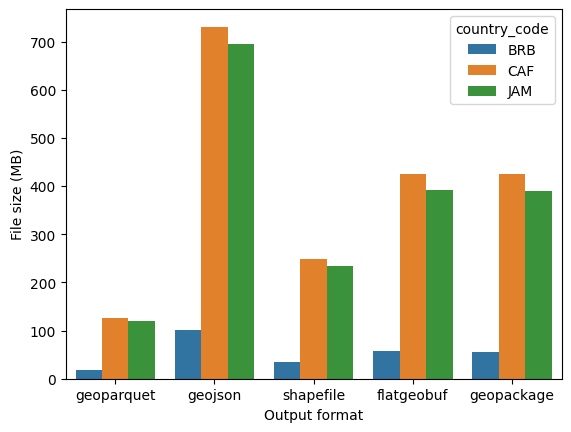

In [9]:
# create a grouped bar plot where y is file size and x is file format and file sizes are grouped by country code
barplot(data=convert_df, x="output_format", y="file_size", title="File size by output format", xlabel="Output format", ylabel="File size (MB)", hue="country_code")

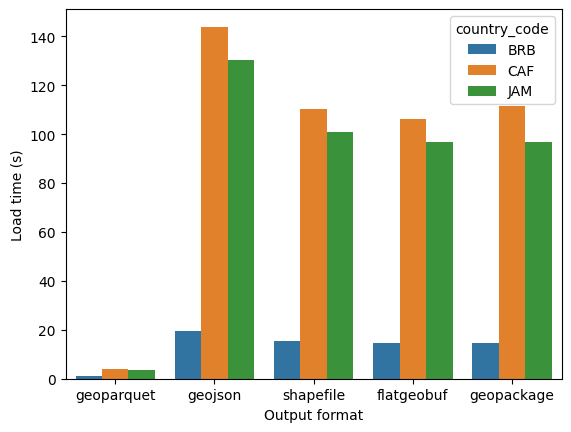

In [10]:
# create a grouped bar plot where y is load time and x is file format and load times are grouped by country code
barplot(data=convert_df, x="output_format", y="load_time", title="Load time by output format", xlabel="Output format", ylabel="Load time (s)", hue="country_code")

/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_1322/3378228224.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_1322/3378228224.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)
/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_1322/3378228224.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_1322/3378228224.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels)


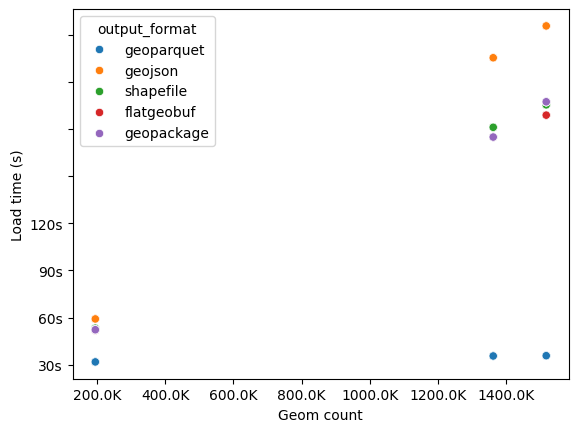

In [11]:
# modify xticks for geom_count to display 200K ticks up to max geom_count in dataset
xticks = [int(i) for i in range(0, max(convert_df["geom_count"]), 200000)]
xticklabels = [f"{i/1000}K" for i in xticks]

print()
# modify yticks for load_time to display 30s ticks up to max load_time in dataset
yticks = [f"{i}s" for i in range(0, max(convert_df["load_time"].astype(int)), 30)]
yticklabels = [f"{i}s" for i in range(0, max(convert_df["load_time"].astype(int)), 30)]

# create a scatter plot where x is geom count and y is load time and points are colored by file format
scatter_plot(data=convert_df, x="geom_count", y="load_time", title="Load time by geom count", xlabel="Geom count", ylabel="Load time (s)", hue="output_format", xticks=xticks, yticks=yticks, xticklabels=xticklabels, yticklabels=yticklabels)

### Querying in-memory with GeoPandas 

Query brainstorming: 
- simple geometry/building count per country
    - visualization: interactive international map with countries shaded or scaled by building count
- distribution of square area of buildings per country or per other attribute
    - comparison of square area distributions between countries
        - how do we compare/match distributions? descriptive statistics? 
- 

In [12]:
# download and load test file
test_country = "ARG"

test_bboxes = [
    [-59.7966,-35.9823,-57.125,-33.8511], # Buenos Aires, La Plata
    [-69.4503,-33.2598,-67.6679,-30.895], # Mendoza, San Juan
    [-69.29,-38.04,-63.21,-35.62], # La Pampa, Santa Rosa
]
    

# display file cols and head
test_file = fetch_geoparquet(test_country, os.path.join(open_buildings_path, "parquet"))
print(f"Using File: {test_file}")
test_gdf, _ = load_geodataframe(test_file, test_country, output_format="parquet", test_load=False) 

/Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/ARG.parquet: 100%|██████████| 2.31G/2.31G [01:33<00:00, 26.4MiB/s] 


Succesfully downloaded ARG.parquet in 94.68725991249084 seconds and saved to /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/ARG.parquet
Using File: /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/ARG.parquet
Successfully loaded ARG.parquet into geopandas dataframe


### Querying from files with DuckDB

In [15]:
import duckdb 
import pandas as pd
import geopandas as gpd

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql
# %config SqlMagic.displaycon = False
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [16]:
# use USA as test country and test querying for Puerto Rico subset using geo bbox 
test_country = "USA"
# fetch test file
test_file = fetch_geoparquet(test_country, os.path.join(open_buildings_path, "parquet"))
print(f"Using File: {test_file}")

# establish duckdb connection
conn = duckdb.connect(database=':memory:')

# Load the SPATIAL extension
conn.execute("INSTALL spatial;")
conn.execute("LOAD spatial;")

# create virtual table from geoparquet file
conn.execute(f"""
    CREATE TABLE buildings AS
    SELECT *
    FROM parquet_scan('{test_file}')
""")

# Puerto Rico rough bbox
PR_bbox = [-68.1972, 17.6079, -65.1945, 18.7991]
min_lon, min_lat, max_lon, max_lat = PR_bbox

# Query to get the subset of data within the bounding box
bbox_query = f"""
    CREATE TABLE puerto_rico_buildings AS
    SELECT *
    FROM buildings
    WHERE 
        ST_Intersects(
            ST_MakeEnvelope({min_lon}, {min_lat}, {max_lon}, {max_lat}, 4326),
            geom
        )
"""

# Execute the query and fetch the results as a DataFrame
result_df = conn.execute(bbox_query).fetchdf()
PR_gdf = gpd.GeoDataFrame(result_df, geometry="geom")

# NOTE: confirm this is not needed as the data is already in the correct CRS
# Set the CRS (Coordinate Reference System) if not already set
gdf.set_crs('EPSG:4326', inplace=True)

# create PR geoparquet dir and file 
pr_dir = os.path.join(open_buildings_path, "parquet")
os.makedirs(pr_dir, exist_ok=True)
pr_file = os.path.join(pr_dir, "PRI.parquet")

# compare gdf export to geoparquet with duckdb query's export 
t1 = time.time()
gdf.to_parquet(pr_file)
t2 = time.time()
print(f"Exported GeoDataFrame to geoparquet in {t2-t1} seconds")
# delete file and export again
os.remove(pr_file)
t1 = time.time()
conn.execute(f""" COPY puerto_rico_buildings TO '{pr_file}' (FORMAT 'parquet') """)
t2 = time.time()
print(f"Exported DuckDB query to geoparquet in {t2-t1} seconds")

USA.parquet already exists at /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/USA.parquet
Using File: /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/USA.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/traitlets/traitlets.py(708): __set__
  /var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_1322/3772392589.py(15): <module>
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3577): run_code
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3517): run_ast_nodes
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3334): run_cell_async
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3130): _run_cell
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3075): run_cell
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/ipkernel.py(449): do_execute
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/kernelbase.py(778): execute_request
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/ipkernel.py(362): execute_request
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/kernelbase.py(534): process_one
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/asyncio/events.py(80): _run
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/asyncio/base_events.py(603): run_forever
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/tornado/platform/asyncio.py(205): start
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel/kernelapp.py(739): start
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/traitlets/config/application.py(1075): launch_instance
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/site-packages/ipykernel_launcher.py(18): <module>
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/runpy.py(86): _run_code
  /Volumes/Expanse/mambaforge/envs/geospatial/lib/python3.10/runpy.py(196): _run_module_as_main


### Visualization with Basemaps

### 3D Data with Overture

# Discussion on cloud-native geospatial data formats

# References
- https://geoparquet.org/
- https://geopandas.org/
- https://radiant.earth/blog/2023/10/what-is-source-cooperative/
- https://guide.cloudnativegeo.org/geoparquet/
- https://medium.com/radiant-earth-insights/performance-explorations-of-geoparquet-and-duckdb-84c0185ed399
- https://medium.com/mapular/overture-maps-a-fusion-of-open-and-commercial-data-for-a-new-era-in-mapping-f26b4b56ad9a
- https://towardsdatascience.com/geospatial-data-engineering-spatial-indexing-18200ef9160b
- https://github.com/opengeospatial/geoparquet/blob/main/format-specs/geoparquet.md 
- https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2